## 2 Integração e Limpeza de Dados

Nesta seção, integramos as fontes, limpamos o dataset e realizamos diagnósticos de qualidade para garantir dados prontos para análise.

### 2.0 Verificação de Pré-requisitos
Esta célula verifica se os três arquivos CSV necessários existem em `data/`.
Se algum arquivo estiver faltando, será impresso um erro e a execução será interrompida.

In [1]:
# Bibliotecas

from pathlib import Path
import sys
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# verifica se os três arquivos csv necessários existem no diretório data/
data_dir = Path('data')
required = ['all_data.csv', 'id_name.csv', 'steam_app_data.csv']
missing = []
for name in required:
    if not (data_dir / name).exists():
        missing.append(name)

# interrompe a execução caso algum arquivo esteja ausente
if missing:
    msg = f'Erro: os seguintes arquivos estão ausentes no diretório {data_dir}: {missing}'
    print(msg)
    sys.exit(1)

print('Todos os arquivos CSV requeridos estão presentes no diretório.')

Todos os arquivos CSV requeridos estão presentes no diretório.


In [3]:
path = "data/"

# carrega só o cabeçalho (sem dados) para economizar memória
steam_columns = pd.read_csv(path + "steam_app_data.csv", nrows=0).columns
all_columns = pd.read_csv(path + "all_data.csv", nrows=0).columns

cols_all = set(all_columns)
cols_steam = set(steam_columns)

# lista completa e ordenada de colunas presentes em ambos os arquivos
all_cols = sorted(list(cols_all.union(cols_steam)))

# cria tabela comparativa mostrando disponibilidade de cada coluna
comparison_df = pd.DataFrame({
    "Coluna": all_cols,
    "Presente em all_data": ["True" if col in cols_all else "False" for col in all_cols],
    "Presente em steam_app_data": ["True" if col in cols_steam else "False" for col in all_cols]
})

display(comparison_df)


,Coluna,Presente em all_data,Presente em steam_app_data
0,Unnamed: 0,True,False
1,about_the_game,False,True
2,achievements,False,True
3,appid,True,False
4,average_2weeks,True,False
5,average_forever,True,False
6,background,False,True
7,categories,False,True
8,ccu,True,False
9,content_descriptors,False,True


In [4]:
# integra os datasets steam_app_data.csv e all_data.csv mantendo apenas colunas relevantes

path = "data/"

chunk_size = 100_000
output_path = path + "merged_data.csv"

# colunas de interesse para análise
cols_keep = [
    'appid', 'name',
    'is_free', 'price', 'initialprice', 'price_overview',
    'owners', 'ccu',
    'positive', 'negative', 'userscore',
    'average_forever', 'median_forever', 'average_2weeks',
    'genres', 'categories',
    'platforms', 'release_date',
    'developers', 'publishers', 'metacritic'
]

# verifica quais colunas existem em cada dataset
steam_columns = pd.read_csv(path + "steam_app_data.csv", nrows=0).columns
all_columns = pd.read_csv(path + "all_data.csv", nrows=0).columns

steam_cols = [c for c in cols_keep if c in steam_columns]
all_cols = [c for c in cols_keep if c in all_columns]

# lê steam_app_data em blocos para economizar memória
steam_chunks = []
for i, chunk in enumerate(pd.read_csv(path + "steam_app_data.csv", usecols=steam_cols + ['steam_appid'], chunksize=chunk_size)):
    chunk.rename(columns={"steam_appid": "appid"}, inplace=True)
    steam_chunks.append(chunk)
    print(f"Processando bloco {i+1} com {len(chunk)} linhas")

steam_data = pd.concat(steam_chunks, ignore_index=True)
del steam_chunks

# carrega all_data (arquivo menor)
all_data = pd.read_csv(path + "all_data.csv", usecols=all_cols + ['appid', 'name'])

# combina os datasets usando appid e name como chave
merged_df = pd.merge(all_data, steam_data, on=["appid", "name"], how="left")

# salva resultado final
merged_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Dataset integrado salvo em {output_path}")
print(f"Dimensões finais: {merged_df.shape[0]:,} linhas por {merged_df.shape[1]} colunas")


Processando bloco 1 com 86538 linhas
Dataset integrado salvo em data/merged_data.csv
Dimensões finais: 94,498 linhas por 21 colunas


### 2.2 Limpeza de Dados
Limpa os dados, padroniza as colunas, converte tipos

In [5]:
import re
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup

path = "data/merged_data.csv"

df = pd.read_csv(path, low_memory=False)
original_shape = df.shape
print(f"Dataset original: {original_shape[0]:,} linhas × {original_shape[1]} colunas")

# remoção de colunas completamente vazias para otimizar o dataset.
df = df.drop(columns=[c for c in df.columns if df[c].isna().all()], errors="ignore")

# padronização dos nomes das colunas para facilitar manipulação.
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# preenchimento de valores ausentes: texto com "desconhecido" e numéricos com a média.
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("desconhecido")
    else:
        df[col] = df[col].fillna(df[col].mean())

# conversão de colunas específicas para garantir tipos corretos.
cols_int = ["appid", "positive", "negative", "ccu", "average_forever", "median_forever", "average_2weeks"]
for c in cols_int:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

cols_float = ["price", "initialprice", "userscore", "metacritic"]
for c in cols_float:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

if "is_free" in df.columns:
    df["is_free"] = df["is_free"].astype(str).str.lower().isin(["true", "1", "yes"])

# extração de preços da coluna json price_overview, convertendo centavos para unidades monetárias.
def extract_price_info(x, key):
    if isinstance(x, str) and "{" in x and "}" in x:
        try:
            fixed = x.replace("'", "\"").replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            value = data.get(key)
            if isinstance(value, (int, float)):
                return value / 100
        except Exception:
            return np.nan
    return np.nan

if "price_overview" in df.columns:
    df["price_final_json"] = df["price_overview"].apply(lambda x: extract_price_info(x, "final"))
    df["price_initial_json"] = df["price_overview"].apply(lambda x: extract_price_info(x, "initial"))

    # consolidação dos preços finais e iniciais usando múltiplas fontes.
    df["price_final"] = df["price_final_json"]
    if "price" in df.columns:
        df["price_final"] = df["price_final"].fillna(df["price"])

    df["price_initial"] = df["price_initial_json"]
    if "initialprice" in df.columns:
        df["price_initial"] = df["price_initial"].fillna(df["initialprice"])
else:
    print("A coluna price_overview não foi encontrada. Utilizando as colunas price e initialprice nos valores originais.")

# extração da moeda do json price_overview.
def extract_currency(x):
    if isinstance(x, str) and "{" in x and "}" in x:
        try:
            fixed = x.replace("'", "\"").replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            return data.get("currency", "desconhecido")
        except Exception:
            return "desconhecido"
    return "desconhecido"

df["currency"] = df["price_overview"].apply(extract_currency) if "price_overview" in df.columns else "desconhecido"

# remoção de tags html e padronização de texto nas colunas categóricas.
text_cols = ["genres", "categories", "developers", "publishers"]
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text() if pd.notnull(x) else x)
        df[c] = df[c].str.lower().str.strip()

# tratamento de outliers usando percentis 1% e 99% para evitar valores extremos.
for col in ["price", "userscore", "metacritic"]:
    if col in df.columns:
        low, high = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lower=low, upper=high)

# conversão de ranges de owners (ex: "10,000 .. 20,000") para valores numéricos usando a média.
def parse_owners_range(val):
    if pd.isna(val):
        return np.nan
    s = str(val).replace(",", "").strip()

    m = re.findall(r"(\d+)", s)
    if len(m) >= 2:
        try:
            nums = [int(m[0]), int(m[1])]
            return np.mean(nums)
        except Exception:
            return np.nan
    elif len(m) == 1:
        return float(m[0])
    return np.nan

if "owners" in df.columns:
    df["owners"] = df["owners"].apply(parse_owners_range)
    print(f"Coluna owners reconstruída com {df['owners'].notna().sum():,} valores válidos")
    print("Amostra de valores da coluna owners:")
    print(df["owners"].dropna().sample(10, random_state=42).to_list())

# extração do score do metacritic quando armazenado como json.
if "metacritic" in df.columns:
    df["metacritic"] = df["metacritic"].apply(
        lambda x: extract_price_info(x, "score") if isinstance(x, str) and "{" in x else x
    )

# remoção de jogos duplicados mantendo apenas a primeira ocorrência.
df = df.drop_duplicates(subset=["appid"], keep="first")

# filtragem de jogos com dados válidos: preço não negativo e gênero informado.
before_filter = df.shape[0]
df = df.loc[df["price_final"] >= 0]
df = df.loc[~df["genres"].isin(["desconhecido", "", "none", "null"])]
removed_missing = before_filter - df.shape[0]

output_path = "data/merged_data_clean.csv"
df.to_csv(output_path, index=False)

print("Relatório de Limpeza")
print(f"Linhas iniciais: {original_shape[0]:,}")
print(f"Linhas finais: {df.shape[0]:,}")
print(f"Linhas removidas: {original_shape[0] - df.shape[0]:,}")
print(f"Linhas removidas por dados faltantes: {removed_missing:,}")
print(f"Arquivo final salvo em: {output_path}")
print("Moedas presentes no dataset final:")
print(df["currency"].value_counts().head(30))


Dataset original: 94,498 linhas × 21 colunas
Coluna owners reconstruída com 94,498 valores válidos
Amostra de valores da coluna owners:
[10000.0, 10000.0, 1500000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 35000.0, 10000.0]
Relatório de Limpeza
Linhas iniciais: 94,498
Linhas finais: 80,845
Linhas removidas: 13,653
Linhas removidas por dados faltantes: 1,655
Arquivo final salvo em: data/merged_data_clean.csv
Moedas presentes no dataset final:
currency
BRL             69459
desconhecido    10677
EUR               275
USD               239
GBP                54
RUB                27
CAD                16
AUD                15
PLN                13
PHP                 8
UAH                 8
CNY                 6
NOK                 6
MYR                 5
MXN                 4
HKD                 4
SGD                 4
ILS                 3
KZT                 3
CLP                 2
COP                 2
SAR                 2
CHF                 2
JPY                 2
IDR         

### 2.1 Enriquecimento com Fontes Externas (Opcional)
Identifique e integre dados externos relevantes (demográficos, econômicos, clima, etc.) usando estratégias de matching (IDs, tempo, geografia, categorias). Documente conflitos e duplicatas.

In [6]:
# converte preços de diferentes moedas para BRL usando API de câmbio e remove registros com preço inválido

input_path = "data/merged_data_clean.csv"
output_path = "data/merged_data_clean_brl.csv"

df = pd.read_csv(input_path, low_memory=False)

price_col = "price_final"
currency_col = "currency"

print(f"Número de linhas no dataset inicial: {len(df):,}")

print("\nDistribuição das moedas mais frequentes no dataset:")
print(df[currency_col].value_counts().head(40))

# identifica moedas únicas presentes no dataset, excluindo valores inválidos
currencies = sorted(df.loc[df[currency_col].notna(), currency_col].unique())
currencies = [c for c in currencies if c not in ("desconhecido", "", "None", "none", None)]
print(f"\nMoedas identificadas para conversão: {currencies}")

# busca taxas de câmbio na API (base BRL), onde 1 BRL = X moeda estrangeira
api_url = "https://api.exchangerate.host/latest"
params = {"base": "BRL", "symbols": ",".join(currencies)}

exchange_rates = {}
use_api = True
try:
    print("\nConsultando taxas de câmbio na API exchangerate.host")
    r = requests.get(api_url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()
    rates = data.get("rates", {})
    exchange_rates = {cur: rates.get(cur) for cur in currencies}
    print(f"Taxas de câmbio obtidas com sucesso: {exchange_rates}")
except Exception as e:
    print(f"Erro ao obter taxas de câmbio da API: {str(e)}")
    use_api = False

# fallback com taxas manuais caso a API falhe
if not use_api or any(v is None for v in exchange_rates.values()):
    exchange_rates_manual = {
        "BRL": 1.0,
        "USD": 0.18,
        "EUR": 0.16,
        "GBP": 0.13,
    }
    for cur in currencies:
        if exchange_rates.get(cur) is None:
            if cur in exchange_rates_manual:
                exchange_rates[cur] = exchange_rates_manual[cur]
            else:
                exchange_rates[cur] = None

# converte preço para BRL usando a fórmula: preço_brl = preço_original / taxa_câmbio
def convert_to_brl(price, currency):
    try:
        price = float(price)
    except Exception:
        return 0.0

    if price == 0:
        return 0.0

    if not currency or str(currency).lower() in ("desconhecido", "none", "nan"):
        return price

    rate = exchange_rates.get(currency)
    if rate in (None, 0):
        return np.nan
    return price / rate


df["price_brl"] = df.apply(lambda r: convert_to_brl(r.get(price_col), r.get(currency_col)), axis=1)

before = len(df)
no_price_mask = df["price_brl"].isna()
print(f"\nNúmero de registros sem conversão de preço válida: {no_price_mask.sum()}")

if no_price_mask.sum() > 0:
    print("\nExemplo de registros com problemas na conversão de preço:")
    cols_show = [currency_col, price_col, "price_overview"] if "price_overview" in df.columns else [currency_col, price_col]
    print(df.loc[no_price_mask, cols_show].head(10).to_string(index=False))

# remove registros onde não foi possível converter o preço para BRL
df = df.loc[~df["price_brl"].isna()].copy()
after_price_filter = len(df)
print(f"\nNúmero de linhas removidas por ausência de preço convertido: {before - after_price_filter:,}")

# remove registros com valores nulos em colunas essenciais
essential_cols = ["userscore", "genres"]
before2 = len(df)
df = df.dropna(subset=essential_cols)
after2 = len(df)
print(f"Número de linhas removidas por ausência de dados em {essential_cols}: {before2 - after2:,}")

df.to_csv(output_path, index=False)
print(f"\nArquivo salvo com sucesso em: {output_path}")
print(f"Número total de linhas no dataset final: {len(df):,}")


Número de linhas no dataset inicial: 80,845

Distribuição das moedas mais frequentes no dataset:
currency
BRL             69459
desconhecido    10677
EUR               275
USD               239
GBP                54
RUB                27
CAD                16
AUD                15
PLN                13
PHP                 8
UAH                 8
CNY                 6
NOK                 6
MYR                 5
MXN                 4
HKD                 4
SGD                 4
ILS                 3
KZT                 3
CLP                 2
COP                 2
SAR                 2
CHF                 2
JPY                 2
IDR                 1
VND                 1
ZAR                 1
NZD                 1
KWD                 1
TWD                 1
INR                 1
AED                 1
KRW                 1
Name: count, dtype: int64

Moedas identificadas para conversão: ['AED', 'AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNY', 'COP', 'EUR', 'GBP', 'HKD', 'IDR', 'ILS', 'INR', 'JPY'

### 2.3 Consultas SQL e Visualizações para Diagnóstico de Qualidade
Heatmaps de missing, boxplots, distribuições antes/depois e consultas que evidenciem problemas e validem correções.

Dados brutos: 94,498 linhas
Dados limpos: 80,704 linhas

Valores ausentes identificados nos dados brutos:
metacritic        90353
price_overview    13991
categories         2474
publishers         2230
developers         1801
genres             1733
release_date       1567
is_free            1567
platforms          1567
price                28
dtype: int64

Valores ausentes identificados nos dados limpos:
price_final_json      10677
price_initial_json    10677
appid                     0
negative                  0
userscore                 0
owners                    0
average_forever           0
average_2weeks            0
median_forever            0
name                      0
dtype: int64


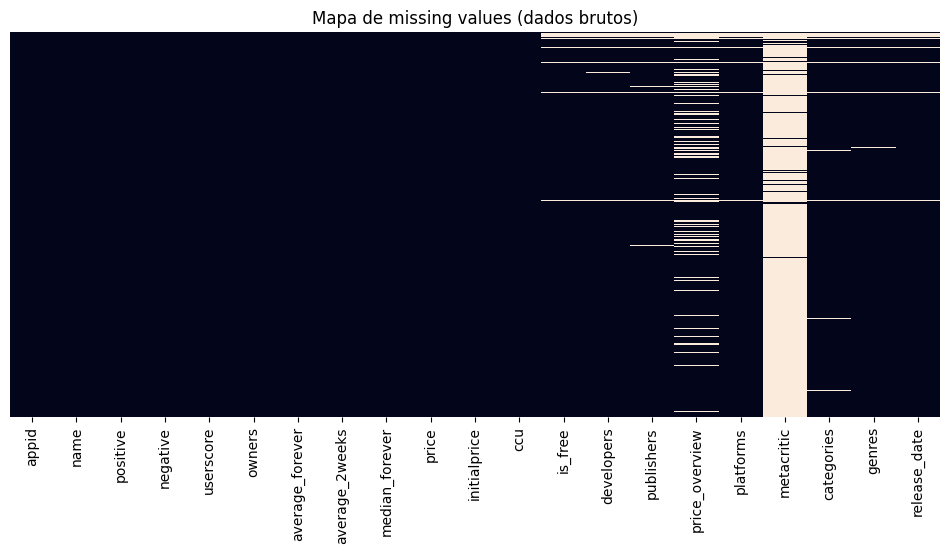

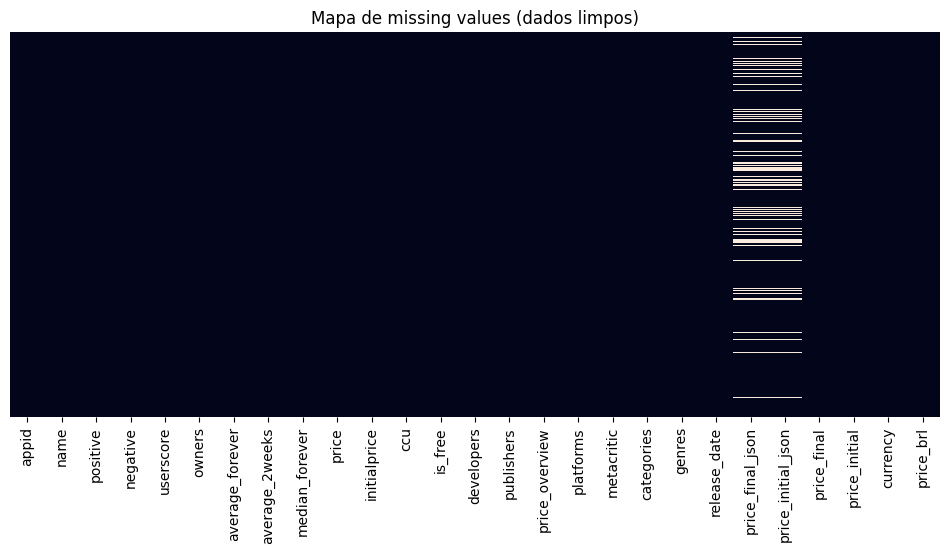

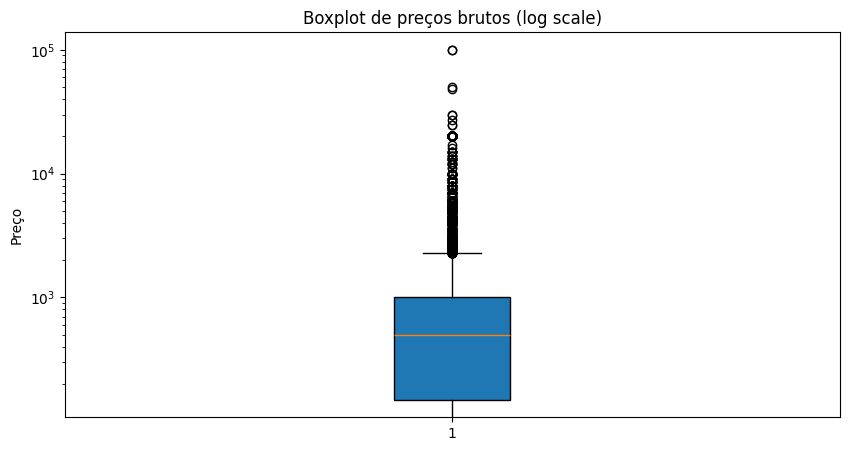

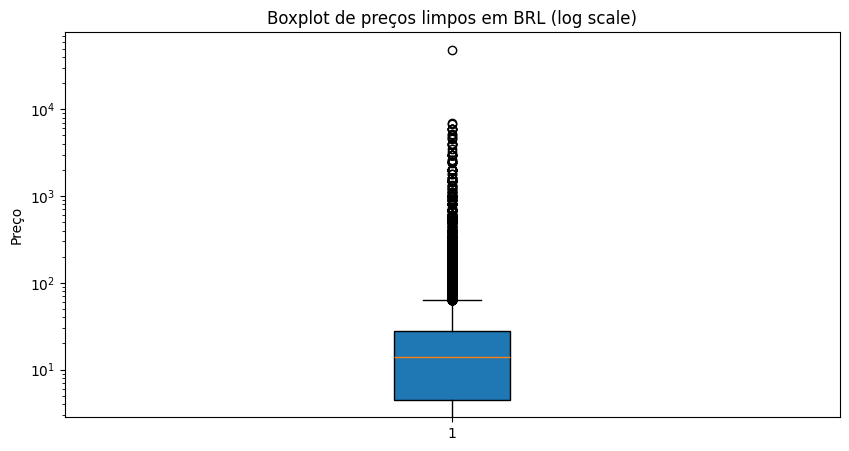

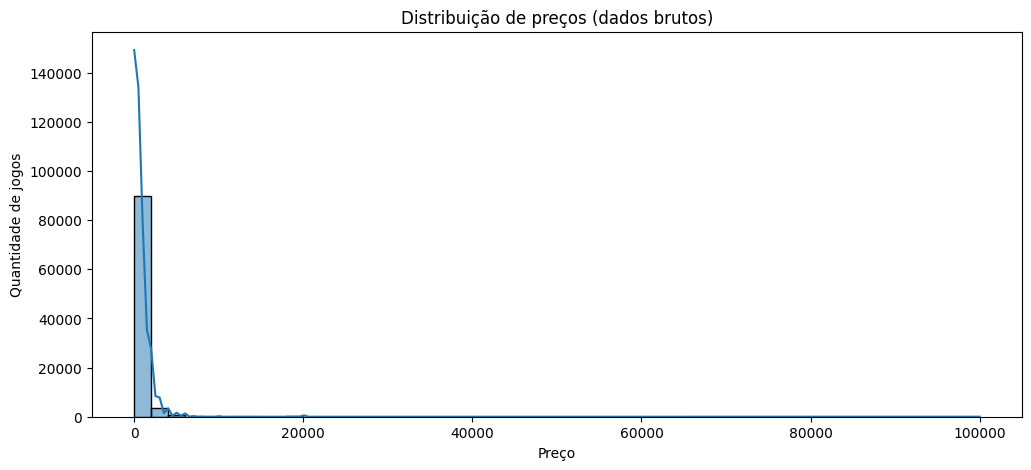

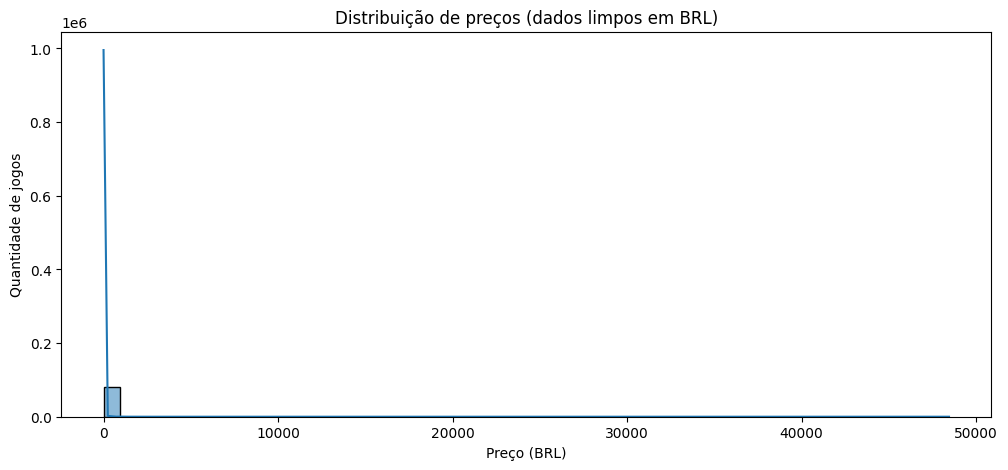


Análise de moedas e preços nos dados brutos:
        currency    qtd    avg_price  max_price
0            BRL  79762   845.662258    99998.0
1   desconhecido  13991   144.606603    48445.0
2            EUR    299  1150.672241     5999.0
3            USD    240  1815.120833     8999.0
4            GBP     55  1936.272727     6999.0
5            RUB     35  1266.571429     4999.0
6            CAD     16  1769.625000     5999.0
7            AUD     15  1333.000000     5999.0
8            PLN     13   804.384615     2999.0
9            PHP      9  1787.888889     3999.0
10           UAH      8  1699.000000     4999.0
11           CNY      6  1282.333333     2999.0
12           NOK      6  1894.000000     5999.0
13           SGD      5  1559.000000     1999.0
14           MYR      5  2299.000000     5999.0
15           MXN      4  1424.000000     2999.0
16           HKD      4  2749.000000     5999.0
17           ILS      3  1995.666667     2999.0
18           KZT      3  1865.666667     3

In [7]:
# carregamento dos datasets bruto e limpo para análise comparativa
df_raw = pd.read_csv("data/merged_data.csv")
df_clean = pd.read_csv("data/merged_data_clean_brl.csv")

print(f"Dados brutos: {len(df_raw):,} linhas")
print(f"Dados limpos: {len(df_clean):,} linhas")

# registra os dataframes no duckdb para permitir consultas sql
duckdb.register("df_raw", df_raw)
duckdb.register("df_clean", df_clean)

# identifica quantidade de valores ausentes em cada coluna
missing_raw = df_raw.isna().sum().sort_values(ascending=False)
missing_clean = df_clean.isna().sum().sort_values(ascending=False)

print("\nValores ausentes identificados nos dados brutos:")
print(missing_raw.head(10))

print("\nValores ausentes identificados nos dados limpos:")
print(missing_clean.head(10))

# visualização espacial dos valores ausentes para identificar padrões
plt.figure(figsize=(12,5))
sns.heatmap(df_raw.isna(), cbar=False, yticklabels=False)
plt.title("Mapa de missing values (dados brutos)")
plt.show()

plt.figure(figsize=(12,5))
sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False)
plt.title("Mapa de missing values (dados limpos)")
plt.show()

# análise de outliers em preços usando boxplot com escala logarítmica
plt.figure(figsize=(10,5))
plt.boxplot(df_raw['price'].fillna(0), patch_artist=True)
plt.yscale('log')
plt.title("Boxplot de preços brutos (log scale)")
plt.ylabel("Preço")
plt.show()

plt.figure(figsize=(10,5))
plt.boxplot(df_clean['price_brl'].fillna(0), patch_artist=True)
plt.yscale('log')
plt.title("Boxplot de preços limpos em BRL (log scale)")
plt.ylabel("Preço")
plt.show()

# comparação da distribuição de preços antes e depois do processo de limpeza
plt.figure(figsize=(12,5))
sns.histplot(df_raw['price'].dropna(), bins=50, kde=True)
plt.title("Distribuição de preços (dados brutos)")
plt.xlabel("Preço")
plt.ylabel("Quantidade de jogos")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_clean['price_brl'].dropna(), bins=50, kde=True)
plt.title("Distribuição de preços (dados limpos em BRL)")
plt.xlabel("Preço (BRL)")
plt.ylabel("Quantidade de jogos")
plt.show()

# extrai informação de moeda do campo price_overview para análise de inconsistências
if 'currency' not in df_raw.columns:
    def extract_currency(x):
        if isinstance(x, str) and "{" in x and "}" in x:
            try:
                return eval(x).get("currency", "desconhecido")
            except:
                return "desconhecido"
        return "desconhecido"
    df_raw['currency'] = df_raw['price_overview'].apply(extract_currency)
    duckdb.register("df_raw", df_raw)

# agrupa dados por moeda para identificar problemas de conversão e valores inconsistentes
query_raw_currency = """
SELECT
    currency,
    COUNT(*) AS qtd,
    AVG(price) AS avg_price,
    MAX(price) AS max_price
FROM df_raw
GROUP BY currency
ORDER BY qtd DESC
"""
raw_inconsistencies = duckdb.sql(query_raw_currency).df()
print("\nAnálise de moedas e preços nos dados brutos:")
print(raw_inconsistencies.head(20))

query_clean_currency = """
SELECT
    currency,
    COUNT(*) AS qtd,
    AVG(price_final) AS avg_price,
    MAX(price_final) AS max_price
FROM df_clean
GROUP BY currency
ORDER BY qtd DESC
"""
clean_inconsistencies = duckdb.sql(query_clean_currency).df()
print("\nAnálise de moedas e preços nos dados limpos:")
print(clean_inconsistencies.head(20))


## 3 Análise Exploratória e Consultas SQL
Nesta seção, preparamos os dados em formato tidy, executamos consultas SQL analíticas e conduzimos análises com visualizações e testes de hipóteses.

## 3.2 Preparação dos Dados em Formato Tidy
### 3.2.1 Organização dos Dados
Transformar o dataset limpo para formato tidy data seguindo os princípios fundamentais: cada
variável forma uma coluna, cada observação forma uma linha e cada tipo de unidade observacional forma uma tabela.

### 3.2.2 Reestruturação Necessária e Export para Parquet
- Salva todas as tabelas tidy em formato Parquet (eficiente para análise)
- Fallback para CSV se Parquet não estiver disponível

In [8]:
import re
import json
import pandas as pd
from dateutil import parser as dparser
import os

# carrega o dataset previamente limpo e convertido para BRL
clean_path = "data/merged_data_clean_brl.csv"
df = pd.read_csv(clean_path, low_memory=False)
print(f"Dataset limpo carregado com {len(df):,} linhas e {df.shape[1]} colunas\n")

# parse de datas em formatos variados (JSON-like, ISO, texto livre)
def parse_release_date(val):
    """Extrai e converte datas de strings variadas (incluindo JSON-like)."""
    if not isinstance(val, str) or not val.strip():
        return pd.NaT
    s = val.strip()

    # tenta extrair data de estruturas JSON com campo 'date'
    if "date" in s and "{" in s:
        try:
            fixed = s.replace("'", '"')
            data = json.loads(fixed)
            if isinstance(data, dict) and "date" in data:
                return pd.to_datetime(data["date"], errors="coerce")
        except Exception:
            pass

    # tenta identificar padrões comuns de data (ex: "12 Jan 2020", "2020-01-12")
    patterns = [
        r"(\d{1,2}\s+[A-Za-z]{3,9},?\s*\d{4})",
        r"([A-Za-z]{3,9}\s+\d{1,2},?\s*\d{4})",
        r"(\d{4}-\d{2}-\d{2})",
        r"(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})"
    ]
    for pat in patterns:
        m = re.search(pat, s)
        if m:
            try:
                return pd.to_datetime(m.group(1), errors="coerce")
            except Exception:
                pass

    # fallback com parser fuzzy para formatos não estruturados
    try:
        return pd.to_datetime(dparser.parse(s, fuzzy=True), errors="coerce")
    except Exception:
        return pd.NaT

print("Convertendo coluna release_date para formato datetime")
df["release_date_parsed"] = df["release_date"].apply(parse_release_date)
ok = df["release_date_parsed"].notna().sum()
print(f"Total de datas convertidas com sucesso: {ok:,} de {len(df):,}\n")

print("Amostra de datas convertidas:")
display(df[["release_date", "release_date_parsed"]].head(10))

DELIMS = r"[;,|/]"

def _clean_token(x: str) -> str:
    if not isinstance(x, str):
        return ""
    return x.strip().strip('"\'[]{}()').strip()

# processa campos multivalor (ex: gêneros, categorias) que podem estar em JSON ou delimitados
def split_multi(val):
    """Divide campo multivalor em lista de tokens normalizados."""
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s.lower() in ("desconhecido", "none", "null", "", "nan"):
        return []

    # listas de dicionários (ex: "[{'description': 'Action'}]")
    if s.startswith("[{") and s.endswith("}]"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            if isinstance(data, list):
                tokens = []
                for item in data:
                    if isinstance(item, dict):
                        if "description" in item:
                            tokens.append(item["description"].strip().lower())
                        else:
                            for v in item.values():
                                if isinstance(v, str):
                                    tokens.append(v.strip().lower())
                                    break
                return tokens
        except Exception:
            pass

    # dicionário com flags booleanas (ex: "{'windows': True, 'mac': False}")
    if s.startswith("{") and s.endswith("}"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            obj = json.loads(fixed)
            if isinstance(obj, dict):
                toks = [k for k, v in obj.items() if bool(v)]
                return [_clean_token(t) for t in toks if _clean_token(t)]
        except Exception:
            pass

    # fallback: divide por delimitadores padrão
    toks = re.split(DELIMS, s)
    return [_clean_token(t) for t in toks if _clean_token(t)]

# cria tabela principal (formato tidy) com colunas escalares
print("Criando tabela principal no formato tidy\n")

scalar_cols_pref = [
    "appid","name","positive","negative","owners",
    "average_forever","average_2weeks","median_forever","price",
    "initialprice","ccu","is_free","developers","publishers",
    "price_overview","platforms","categories","genres",
    "release_date_parsed","price_final_json","price_initial_json",
    "price_final","price_initial","currency","price_brl"
]
scalar_cols = [c for c in scalar_cols_pref if c in df.columns]

games = df[scalar_cols].copy()
games.rename(columns={"release_date_parsed": "release_date"}, inplace=True)

# diagnóstico da coluna 'owners' para validar tipos de dados
print("Diagnóstico da coluna owners")
if "owners" in games.columns:
    print(f"Total de linhas: {len(games):,}")
    print(f"Valores nulos: {games['owners'].isna().sum():,}")
    print(f"Valores iguais a zero: {(games['owners'] == 0).sum():,}")
    print(f"Valores únicos: {games['owners'].nunique():,}")

    print("\nTipos de dados detectados:")
    print(games['owners'].apply(type).value_counts().head())

    print("\nAmostra aleatória de valores da coluna owners:")
    print(games['owners'].dropna().sample(10, random_state=42).to_list())

    mask_str = games['owners'].apply(lambda x: isinstance(x, str))
    if mask_str.any():
        print("\nColuna owners contém valores do tipo string. Amostra de 10 registros:")
        print(games.loc[mask_str, 'owners'].head(10).to_list())
else:
    print("Coluna owners não encontrada no dataframe\n")

# remove duplicatas por appid e converte tipos numéricos
if "appid" in games.columns:
    games = games.drop_duplicates(subset=["appid"], keep="first")
    games["appid"] = pd.to_numeric(games["appid"], errors="coerce").astype("Int64")

for num_col in ["positive", "negative", "price", "initialprice", "price_final", "price_brl", "ccu", "owners"]:
    if num_col in games.columns:
        games[num_col] = pd.to_numeric(games[num_col], errors="coerce")

# recalcula userscore (percentual de avaliações positivas) em escala 0-100
print("\nRecalculando coluna userscore a partir das avaliações")
mask = (games["positive"] + games["negative"]) > 0
games.loc[mask, "userscore"] = games.loc[mask, "positive"] / (
    games.loc[mask, "positive"] + games.loc[mask, "negative"]
)
games["userscore"] = (games["userscore"].clip(0, 1) * 100).round(2)

print(f"Userscore recalculado para {mask.sum():,} jogos com avaliações válidas\n")

print("Amostra de valores recalculados:")
display(games.loc[mask, ["name", "positive", "negative", "userscore"]].head(10))

print(f"\nTabela games criada com {len(games):,} jogos e {games.shape[1]} colunas\n")
print("Amostra da tabela games:")
display(games.head(5))

# versão segura do split para publishers/developers (preserva nomes com vírgula)
def split_multi_safe(val):
    """Versão segura — não quebra nomes com vírgulas (para publishers/developers)."""
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s.lower() in ("desconhecido", "none", "null", "", "nan"):
        return []

    # processa listas JSON-like
    if s.startswith("[") and s.endswith("]"):
        try:
            fixed = s.replace("'", '"').replace("False", "false").replace("True", "true")
            data = json.loads(fixed)
            if isinstance(data, list):
                tokens = []
                for item in data:
                    if isinstance(item, str):
                        tokens.append(item.strip().lower())
                    elif isinstance(item, dict):
                        desc = item.get("description") or next(iter(item.values()), "")
                        if isinstance(desc, str):
                            tokens.append(desc.strip().lower())
                return [t for t in tokens if t]
        except Exception:
            pass

    # só divide se houver separadores explícitos (evita quebrar nomes complexos)
    if re.search(r"[;/|]", s):
        toks = re.split(r"[;/|]", s)
        return [_clean_token(t.lower()) for t in toks if _clean_token(t)]

    return [_clean_token(s.lower())]

# cria tabelas normalizadas (formato long) para relacionamentos N:N
print("Criando tabelas normalizadas no formato long\n")

multi_maps = {
    "genres": "games_genres",
    "categories": "games_categories",
    "developers": "games_developers",
    "publishers": "games_publishers",
    "platforms": "games_platforms",
}

norm_tables = {}
for col, tbl_name in multi_maps.items():
    if col not in df.columns:
        print(f"Coluna {col} não encontrada. Tabela {tbl_name} será omitida")
        continue

    tmp = df[["appid", col]].copy() if "appid" in df.columns else df[[col]].copy()
    
    # usa split seguro para publishers/developers
    if col in ["publishers", "developers"]:
        tmp[col] = tmp[col].apply(split_multi_safe)
    else:
        tmp[col] = tmp[col].apply(split_multi)

    tmp = tmp.explode(col)
    tmp[col] = tmp[col].fillna("").astype(str).str.strip().str.lower()
    tmp = tmp.loc[tmp[col].ne("") & ~tmp[col].isin(["desconhecido", "none", "null"])]
    subset_cols = ["appid", col] if "appid" in tmp.columns else [col]
    tmp = tmp.drop_duplicates(subset=subset_cols).reset_index(drop=True)
    norm_tables[tbl_name] = tmp
    print(f"Tabela {tbl_name} criada com {len(tmp):,} relações")

for tbl_name, tdf in norm_tables.items():
    print(f"\nAmostra da tabela {tbl_name}:")
    display(tdf.head(5))

# exporta todas as tabelas em formato parquet (ou csv se não houver engine disponível)
print("\nExportando tabelas em formato Parquet\n")

parquet_dir = "data/tidy"
os.makedirs(parquet_dir, exist_ok=True)

try:
    import pyarrow as pa
    engine = "pyarrow"
    print("Engine disponível: pyarrow\n")
except ImportError:
    try:
        import fastparquet
        engine = "fastparquet"
        print("Engine disponível: fastparquet\n")
    except ImportError:
        engine = None
        print("Nenhum engine Parquet disponível. As tabelas serão salvas em formato CSV\n")

def save_table(df, name, description):
    if engine:
        path = f"{parquet_dir}/{name}.parquet"
        df.to_parquet(path, engine=engine, index=False, compression="snappy")
    else:
        path = f"{parquet_dir}/{name}.csv"
        df.to_csv(path, index=False)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    print(f"{description}")
    print(f"Arquivo salvo em {path} com tamanho de {size_mb:.2f} MB")

save_table(games, "games", f"Tabela principal games exportada com {len(games):,} linhas")
for tbl_name, tdf in norm_tables.items():
    save_table(tdf, tbl_name, f"Tabela {tbl_name} exportada com {len(tdf):,} linhas")

print("\nExportação concluída com sucesso")


Dataset limpo carregado com 80,704 linhas e 27 colunas

Convertendo coluna release_date para formato datetime
Total de datas convertidas com sucesso: 80,480 de 80,704

Amostra de datas convertidas:


,release_date,release_date_parsed
0,"{'coming_soon': False, 'date': '1 Nov, 2000'}",2000-11-01
1,"{'coming_soon': False, 'date': '1 Apr, 1999'}",1999-04-01
2,"{'coming_soon': False, 'date': '1 May, 2003'}",2003-05-01
3,"{'coming_soon': False, 'date': '1 Jun, 2001'}",2001-06-01
4,"{'coming_soon': False, 'date': '1 Nov, 1999'}",1999-11-01
5,"{'coming_soon': False, 'date': '1 Nov, 2000'}",2000-11-01
6,"{'coming_soon': False, 'date': '19 Nov, 1998'}",1998-11-19
7,"{'coming_soon': False, 'date': '1 Mar, 2004'}",2004-03-01
8,"{'coming_soon': False, 'date': '1 Jun, 2001'}",2001-06-01
9,"{'coming_soon': False, 'date': '1 Nov, 2004'}",2004-11-01


Criando tabela principal no formato tidy

Diagnóstico da coluna owners
Total de linhas: 80,704
Valores nulos: 0
Valores iguais a zero: 0
Valores únicos: 13

Tipos de dados detectados:
owners
<class 'float'>    80704
Name: count, dtype: int64

Amostra aleatória de valores da coluna owners:
[35000.0, 10000.0, 750000.0, 350000.0, 750000.0, 10000.0, 10000.0, 10000.0, 10000.0, 350000.0]

Recalculando coluna userscore a partir das avaliações
Userscore recalculado para 80,249 jogos com avaliações válidas

Amostra de valores recalculados:


,name,positive,negative,userscore
0,Counter-Strike,243818,6427,97.43
1,Team Fortress Classic,7602,1136,87.00
2,Day of Defeat,6414,688,90.31
3,Deathmatch Classic,2618,545,82.77
4,Half-Life: Opposing Force,24363,1198,95.31
5,Ricochet,4989,1039,82.76
6,Half-Life,143086,5135,96.54
7,Counter-Strike: Condition Zero,24271,2287,91.39
8,Half-Life: Blue Shift,17384,1410,92.50
9,Counter-Strike: Source,175426,6808,96.26



Tabela games criada com 80,704 jogos e 26 colunas

Amostra da tabela games:


,appid,name,positive,negative,owners,average_forever,average_2weeks,median_forever,price,initialprice,...,categories,genres,release_date,price_final_json,price_initial_json,price_final,price_initial,currency,price_brl,userscore
0,10,Counter-Strike,243818,6427,15000000.0,12222,563,204,199.0,999.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2000-11-01,8.19,8.19,8.19,8.19,EUR,51.1875,97.43
1,20,Team Fortress Classic,7602,1136,1500000.0,361,6722,15,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",1999-04-01,16.99,16.99,16.99,16.99,BRL,16.9900,87.00
2,30,Day of Defeat,6414,688,7500000.0,859,3485,23,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2003-05-01,16.99,16.99,16.99,16.99,BRL,16.9900,90.31
3,40,Deathmatch Classic,2618,545,7500000.0,353,4,10,499.0,499.0,...,"[{'id': 1, 'description': 'multi-player'}, {'i...","[{'id': '1', 'description': 'action'}]",2001-06-01,16.99,16.99,16.99,16.99,BRL,16.9900,82.77
4,50,Half-Life: Opposing Force,24363,1198,3500000.0,528,78,162,499.0,499.0,...,"[{'id': 2, 'description': 'single-player'}, {'...","[{'id': '1', 'description': 'action'}]",1999-11-01,16.99,16.99,16.99,16.99,BRL,16.9900,95.31


Criando tabelas normalizadas no formato long

Tabela games_genres criada com 230,999 relações
Tabela games_categories criada com 365,195 relações
Tabela games_developers criada com 87,268 relações
Tabela games_publishers criada com 83,243 relações
Tabela games_platforms criada com 108,001 relações

Amostra da tabela games_genres:


,appid,genres
0,10,action
1,20,action
2,30,action
3,40,action
4,50,action



Amostra da tabela games_categories:


,appid,categories
0,10,multi-player
1,10,pvp
2,10,online pvp
3,10,shared/split screen pvp
4,10,color alternatives



Amostra da tabela games_developers:


,appid,developers
0,10,valve
1,20,valve
2,30,valve
3,40,valve
4,50,gearbox software



Amostra da tabela games_publishers:


,appid,publishers
0,10,valve
1,20,valve
2,30,valve
3,40,valve
4,50,valve



Amostra da tabela games_platforms:


,appid,platforms
0,10,windows
1,10,mac
2,10,linux
3,20,windows
4,20,mac



Exportando tabelas em formato Parquet

Engine disponível: pyarrow

Tabela principal games exportada com 80,704 linhas
Arquivo salvo em data/tidy/games.parquet com tamanho de 6.62 MB
Tabela games_genres exportada com 230,999 linhas
Arquivo salvo em data/tidy/games_genres.parquet com tamanho de 0.96 MB
Tabela games_categories exportada com 365,195 linhas
Arquivo salvo em data/tidy/games_categories.parquet com tamanho de 1.22 MB
Tabela games_developers exportada com 87,268 linhas
Arquivo salvo em data/tidy/games_developers.parquet com tamanho de 1.30 MB
Tabela games_publishers exportada com 83,243 linhas
Arquivo salvo em data/tidy/games_publishers.parquet com tamanho de 1.17 MB
Tabela games_platforms exportada com 108,001 linhas
Arquivo salvo em data/tidy/games_platforms.parquet com tamanho de 0.56 MB

Exportação concluída com sucesso


A visualização de boxplot confirma a presença de poucos valores extremos acima de R$3.000, representando o percentil 99.


Esses valores são mantidos como outliers legítimos, pois refletem edições premium e não erros de coleta.


A maioria dos jogos pagos apresenta preços concentrados entre R$0 e R$1.000.

## 3.3 Consultas SQL Analíticas (5+ obrigatórias)
Desenvolver consultas que revelem insights interessantes a partir dos dados em formato tidy, explorando:
• Agregações complexas: Análises por grupos e períodos (ou equivalentes)
• Análises temporais: Funções de janela para tendências e rankings
• Consultas hierárquicas: CTEs para análises em múltiplos níveis


### 1) 

In [9]:
import duckdb
import pandas as pd

# registra as tabelas tidy no duckdb a partir dos arquivos parquet
duckdb.sql("""
    CREATE OR REPLACE TABLE games AS SELECT * FROM read_parquet('data/tidy/games.parquet');
    CREATE OR REPLACE TABLE games_genres AS SELECT * FROM read_parquet('data/tidy/games_genres.parquet');
    CREATE OR REPLACE TABLE games_publishers AS SELECT * FROM read_parquet('data/tidy/games_publishers.parquet');
    CREATE OR REPLACE TABLE games_developers AS SELECT * FROM read_parquet('data/tidy/games_developers.parquet');
""")

# consulta 1: identifica os 10 gêneros com maior quantidade de jogos
print("Consulta 1: Gêneros mais populares por quantidade de jogos")
query1 = """
SELECT 
    gg.genres,
    COUNT(*) AS qtd_jogos
FROM games g
JOIN games_genres gg ON g.appid = gg.appid
GROUP BY gg.genres
ORDER BY qtd_jogos DESC
LIMIT 10
"""
res1 = duckdb.sql(query1).df()
print(res1, "\n")

# consulta 2: calcula o preço médio por gênero (apenas jogos pagos com amostra significativa)
print("Consulta 2: Preço médio por gênero em reais brasileiros")
query2 = """
SELECT 
    gg.genres,
    ROUND(AVG(g.price_brl), 2) AS preco_medio,
    COUNT(*) AS qtd
FROM games g
JOIN games_genres gg ON g.appid = gg.appid
WHERE g.price_brl > 0
GROUP BY gg.genres
HAVING COUNT(*) > 30
ORDER BY preco_medio DESC
LIMIT 10
"""
res2 = duckdb.sql(query2).df()
print(res2, "\n")

# consulta 3: analisa a evolução temporal dos lançamentos agrupados por ano
print("Consulta 3: Tendência temporal de lançamentos por ano")
query3 = """
SELECT 
    EXTRACT(YEAR FROM release_date) AS ano,
    COUNT(*) AS qtd_jogos
FROM games
WHERE release_date IS NOT NULL
GROUP BY ano
ORDER BY ano
"""
res3 = duckdb.sql(query3).df()
print(res3.head(10), "\n")

# consulta 4: lista as publishers mais prolíficas em número de jogos publicados
print("Consulta 4: Publishers com maior número de jogos publicados")
query4 = """
SELECT 
    gp.publishers,
    COUNT(DISTINCT g.appid) AS qtd_jogos
FROM games g
JOIN games_publishers gp ON g.appid = gp.appid
GROUP BY gp.publishers
ORDER BY qtd_jogos DESC
LIMIT 10
"""
res4 = duckdb.sql(query4).df()
print(res4, "\n")

# consulta 5: identifica desenvolvedores com melhor avaliação média (mínimo 10 jogos para garantir relevância estatística)
print("Consulta 5: Desenvolvedores com melhor avaliação média considerando no mínimo 10 jogos")

query6 = """
SELECT 
    gd.developers,
    COUNT(DISTINCT g.appid) AS num_jogos,
    ROUND(AVG(g.userscore), 2) AS avg_userscore,
    ROUND(AVG(g.price_brl), 2) AS avg_price_brl
FROM games g
JOIN games_developers gd ON g.appid = gd.appid
WHERE g.userscore IS NOT NULL AND g.userscore > 0
GROUP BY gd.developers
HAVING COUNT(DISTINCT g.appid) >= 10
ORDER BY avg_userscore DESC
LIMIT 10
"""
res6 = duckdb.sql(query6).df()
print(res6, "\n")


Consulta 1: Gêneros mais populares por quantidade de jogos
         genres  qtd_jogos
0         indie      57962
1        action      34374
2        casual      33108
3     adventure      32264
4    simulation      16788
5      strategy      16352
6           rpg      14583
7  early access       8156
8  free to play       4376
9        sports       3715 

Consulta 2: Preço médio por gênero em reais brasileiros
                  genres  preco_medio  qtd
0           free to play       588.78  196
1      software training       170.47  124
2       video production       167.12  186
3       audio production       158.14  142
4         web publishing       138.94   63
5  massively multiplayer       103.07  948
6              education        99.54  226
7   animation & modeling        87.78  279
8          photo editing        87.67  116
9       game development        86.54  186 

Consulta 3: Tendência temporal de lançamentos por ano
    ano  qtd_jogos
0  1969          1
1  1997          2


Carregando tabelas do banco de dados
Tabela games: 80,704 registros
Tabela games_genres: 230,999 registros
Tabela games_platforms: 108,001 registros

Resumo da disponibilidade de dados por variável:
price_brl            possui 80,704 valores válidos de 80,704 registros
rating_ratio         possui 80,249 valores válidos de 80,704 registros
owners               possui 80,704 valores válidos de 80,704 registros
ccu                  possui 80,704 valores válidos de 80,704 registros
average_forever      possui 80,704 valores válidos de 80,704 registros

Análise univariada das distribuições das variáveis principais


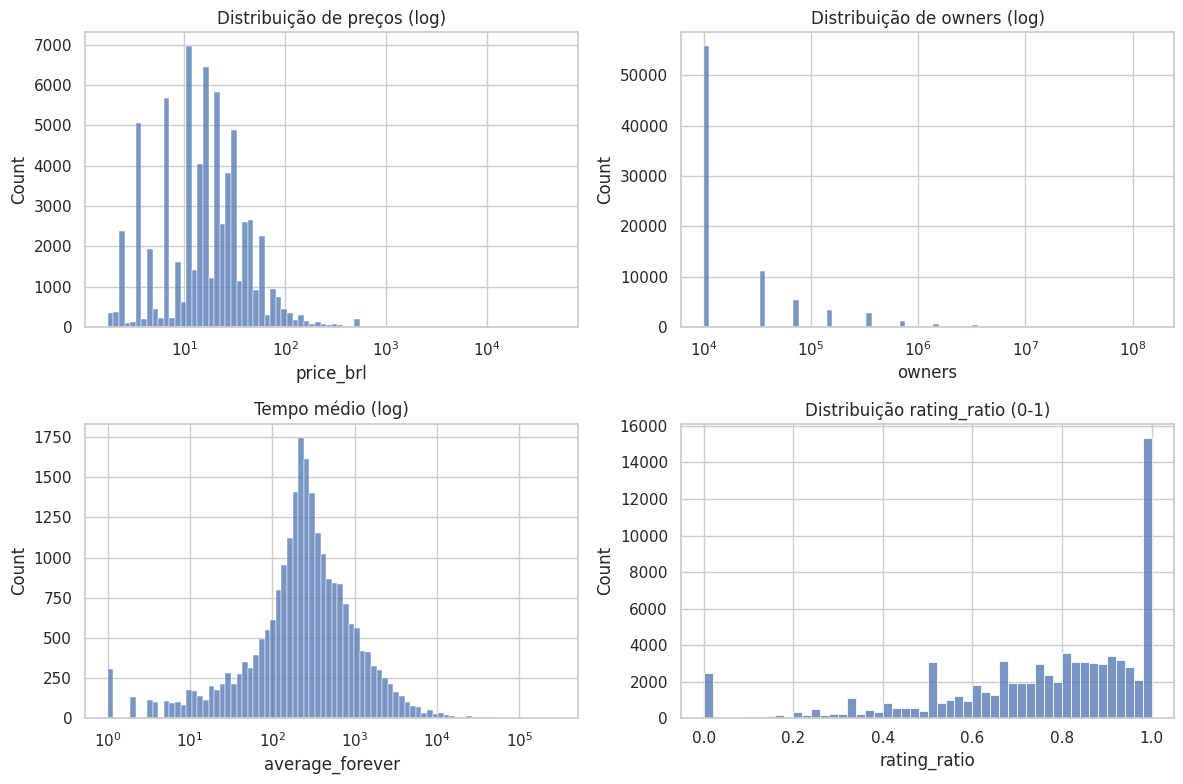


Análise bivariada da relação entre preço e avaliação


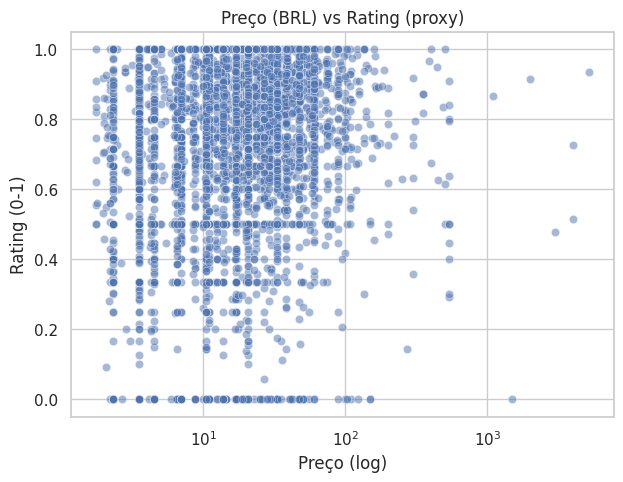

Correlação de Spearman entre preço e rating_ratio: rho=0.0846, p=1.964e-127

Hipótese 1: comparação entre jogos gratuitos e pagos em relação ao número de proprietários
Amostra de jogos gratuitos: 6,524 registros, jogos pagos: 74,180 registros
Teste de Mann-Whitney para proprietários de jogos gratuitos versus pagos: U=291594892, p=7.945e-249


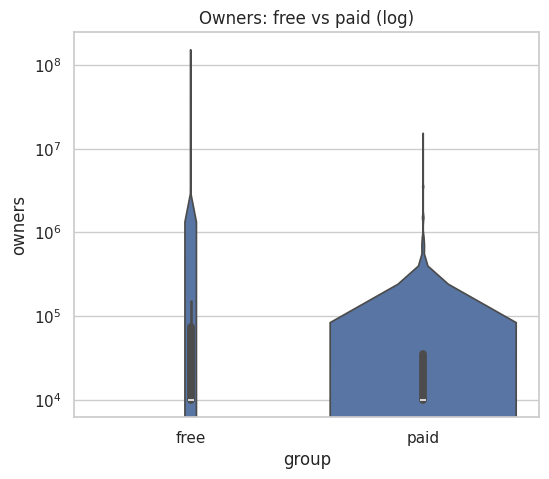


Hipótese 2: análise da correlação entre avaliações negativas e número de jogadores simultâneos
Correlação de Spearman entre avaliações negativas e CCU: rho=0.5125, p=0


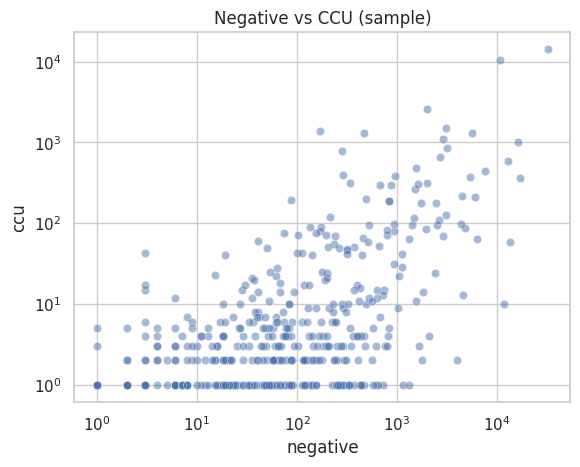


Hipótese 3: comparação entre jogos multiplataforma e jogos de plataforma única
Teste de Mann-Whitney para jogos multiplataforma versus plataforma única: U=653391303, p=9.388e-191


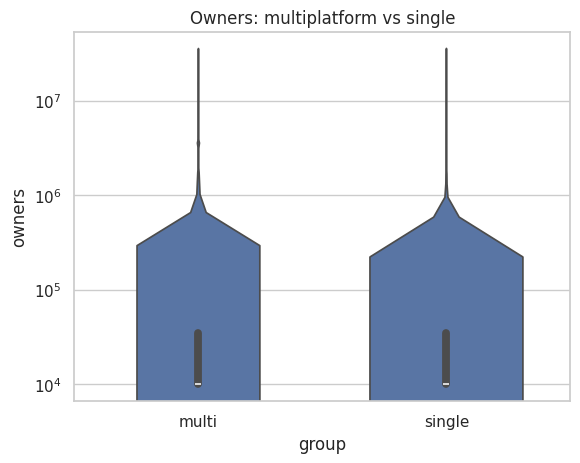


Hipótese 4: análise da relação entre tempo médio de jogo e avaliação
Correlação de Spearman entre tempo médio de jogo e rating: rho=-0.0662, p=1.068e-78


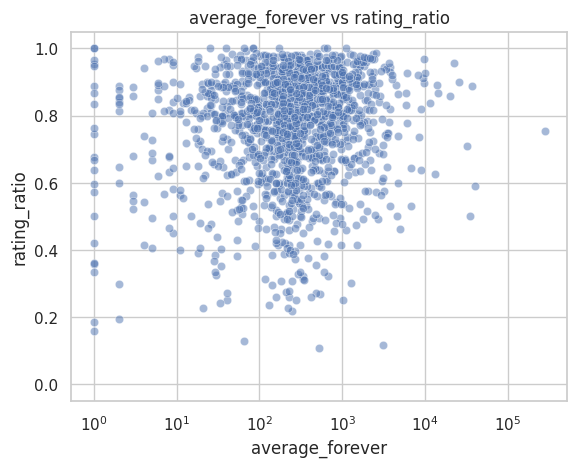


Hipótese 5: comparação de tempo médio de jogo entre jogos multiplayer e singleplayer
genre_type
other                41538
singleplayer_like    37366
multiplayer_like      1800
Name: count, dtype: int64


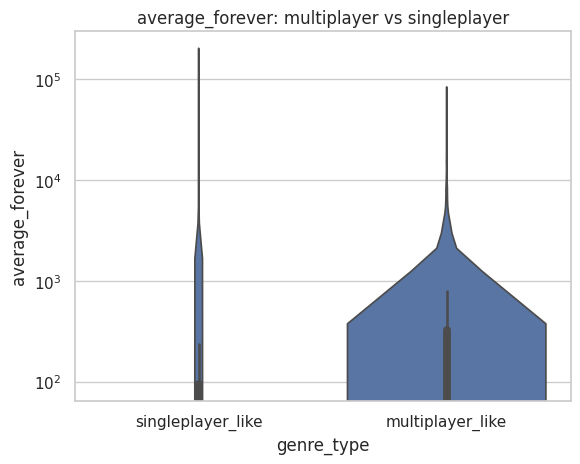

Teste de Mann-Whitney para tempo médio de jogo em multiplayer versus singleplayer: U=38618326, p=1.038e-38

Matriz de correlação de Spearman entre variáveis numéricas
                        price_brl  rating_ratio  userscore_recalc_0_100  \
price_brl                   1.000         0.085                   0.085   
rating_ratio                0.085         1.000                   1.000   
userscore_recalc_0_100      0.085         1.000                   1.000   
average_forever             0.154        -0.066                  -0.066   
owners                      0.050        -0.036                  -0.036   
ccu                         0.273         0.071                   0.071   
positive                    0.169         0.077                   0.077   
negative                    0.111        -0.455                  -0.455   

                        average_forever  owners    ccu  positive  negative  
price_brl                         0.154   0.050  0.273     0.169     0.111  
rat

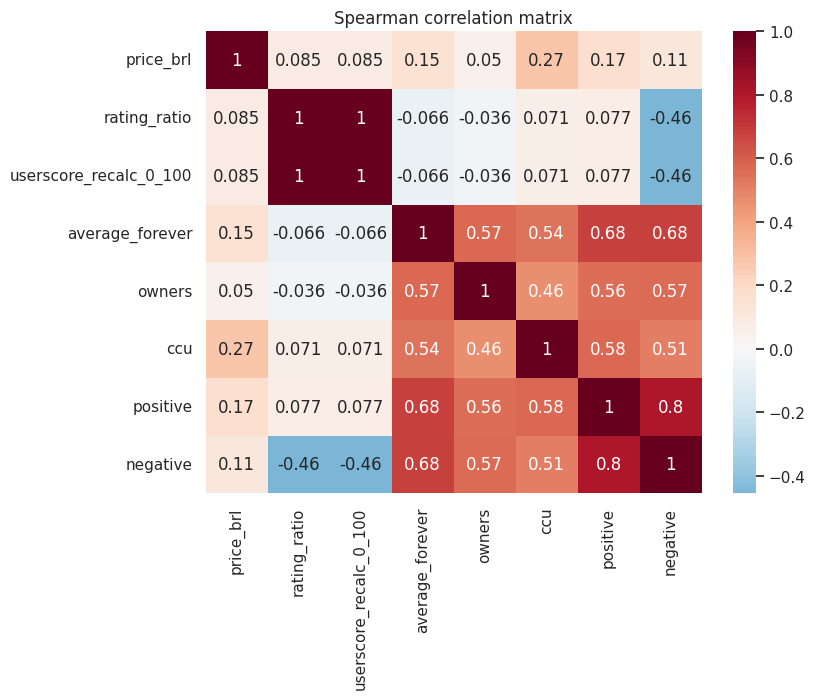


Resumo geral da análise
Total de jogos analisados: 80,704
Jogos pagos identificados: 74,180
Correlação de Spearman entre preço e rating: 0.085 com valor p=1.96e-127
Testes realizados: Mann-Whitney para proprietários de jogos gratuitos versus pagos, correlação de Spearman entre avaliações negativas e CCU, comparação entre jogos multiplataforma e plataforma única, correlação entre tempo médio de jogo e avaliação.

Observações metodológicas: as distribuições apresentam viés significativo, justificando o uso de testes estatísticos não paramétricos. Ajuste as palavras-chave de classificação de gênero conforme necessário para análises futuras.

Interpretação automática dos resultados estatísticos
A correlação de Spearman entre preço e rating é positiva com coeficiente 0.085, sendo estatisticamente significativa com valor p=1.96e-127.
Este resultado sugere uma relação muito fraca, indicando que jogos mais caros não necessariamente apresentam avaliações melhores.

Análise da diferença entre j

In [ ]:
# análise exploratória e testes de hipótese sobre dados tidy de jogos da Steam usando seaborn e matplotlib

import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import duckdb

sns.set(style="whitegrid")

# carregamento das tabelas normalizadas
parquet_dir = Path("data/tidy")
files = {
    "games": parquet_dir / "games.parquet",
    "games_genres": parquet_dir / "games_genres.parquet",
    "games_developers": parquet_dir / "games_developers.parquet",
    "games_publishers": parquet_dir / "games_publishers.parquet",
    "games_platforms": parquet_dir / "games_platforms.parquet",
}

def read_table(path):
    """tenta ler parquet, faz fallback para csv se necessário"""
    if path.exists():
        try:
            return pd.read_parquet(path)
        except Exception as e:
            print(f"Erro ao ler arquivo parquet {path}: {e}")
    csv_path = path.with_suffix(".csv")
    if csv_path.exists():
        print(f"Utilizando arquivo CSV alternativo: {csv_path}")
        return pd.read_csv(csv_path)
    raise FileNotFoundError(f"Arquivo não encontrado: {path}")

print("Carregando tabelas do banco de dados")
games = read_table(files["games"])
games_genres = read_table(files["games_genres"])
games_developers = read_table(files["games_developers"])
games_publishers = read_table(files["games_publishers"])
games_platforms = read_table(files["games_platforms"])

print(f"Tabela games: {len(games):,} registros")
print(f"Tabela games_genres: {len(games_genres):,} registros")
print(f"Tabela games_platforms: {len(games_platforms):,} registros")

# preparação e limpeza dos dados numéricos
for col in ["price_brl","is_free","positive","negative","owners","average_forever","ccu","userscore","metacritic"]:
    if col not in games.columns:
        games[col] = np.nan

num_cols = ["price_brl","positive","negative","owners","average_forever","ccu","userscore","metacritic"]
for c in num_cols:
    games[c] = pd.to_numeric(games[c], errors="coerce")

# calcula rating como razão entre avaliações positivas e totais
mask_votes = (games["positive"].fillna(0)+games["negative"].fillna(0))>0
games["rating_ratio"] = np.where(mask_votes,
                                 games["positive"]/(games["positive"]+games["negative"]),
                                 np.nan)
games["rating_ratio"] = games["rating_ratio"].clip(0,1)
games["userscore_recalc_0_100"] = (games["rating_ratio"]*100).round(2)

print("\nResumo da disponibilidade de dados por variável:")
for c in ["price_brl","rating_ratio","owners","ccu","average_forever"]:
    print(f"{c:20s} possui {games[c].notna().sum():,} valores válidos de {len(games):,} registros")

paid_mask = (games["is_free"]==False) & (games["price_brl"].notna())
free_mask = (games["is_free"]==True)

# análise univariada: distribuições de variáveis chave
print("\nAnálise univariada das distribuições das variáveis principais")
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.histplot(games["price_brl"], bins=80, log_scale=True, ax=axes[0,0])
axes[0,0].set_title("Distribuição de preços (log)")
sns.histplot(games["owners"], bins=80, log_scale=True, ax=axes[0,1])
axes[0,1].set_title("Distribuição de owners (log)")
sns.histplot(games["average_forever"], bins=80, log_scale=True, ax=axes[1,0])
axes[1,0].set_title("Tempo médio (log)")
sns.histplot(games["rating_ratio"].dropna(), bins=50, ax=axes[1,1])
axes[1,1].set_title("Distribuição rating_ratio (0-1)")
plt.tight_layout()
plt.show()

# análise bivariada: relação entre preço e avaliação
print("\nAnálise bivariada da relação entre preço e avaliação")
df_scatter = games.loc[games["price_brl"].notna() & games["rating_ratio"].notna()]
if len(df_scatter)>5000:
    df_scatter = df_scatter.sample(5000, random_state=42)

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_scatter, x="price_brl", y="rating_ratio", alpha=0.5)
plt.xscale("log")
plt.title("Preço (BRL) vs Rating (proxy)")
plt.xlabel("Preço (log)")
plt.ylabel("Rating (0-1)")
plt.show()

# teste de correlação não-paramétrica entre preço e rating
mask_common = games["price_brl"].notna() & games["rating_ratio"].notna()
corr_spearman = stats.spearmanr(games.loc[mask_common,"price_brl"],
                                games.loc[mask_common,"rating_ratio"])
print(f"Correlação de Spearman entre preço e rating_ratio: rho={corr_spearman.correlation:.4f}, p={corr_spearman.pvalue:.4g}")

# hipótese 1: jogos gratuitos têm mais donos que pagos
print("\nHipótese 1: comparação entre jogos gratuitos e pagos em relação ao número de proprietários")
owners_free = games.loc[free_mask, "owners"].dropna()
owners_paid = games.loc[paid_mask, "owners"].dropna()
print(f"Amostra de jogos gratuitos: {len(owners_free):,} registros, jogos pagos: {len(owners_paid):,} registros")

u = stats.mannwhitneyu(owners_free, owners_paid, alternative="greater")
print(f"Teste de Mann-Whitney para proprietários de jogos gratuitos versus pagos: U={u.statistic:.0f}, p={u.pvalue:.4g}")

df_box = pd.DataFrame({
    "owners": pd.concat([owners_free.sample(min(2000,len(owners_free)), random_state=1),
                         owners_paid.sample(min(2000,len(owners_paid)), random_state=1)]),
    "group": ["free"]*min(2000,len(owners_free)) + ["paid"]*min(2000,len(owners_paid))
})
plt.figure(figsize=(6,5))
sns.violinplot(data=df_box, x="group", y="owners", inner="box")
plt.yscale("log")
plt.title("Owners: free vs paid (log)")
plt.show()

# hipótese 2: correlação entre avaliações negativas e jogadores simultâneos
print("\nHipótese 2: análise da correlação entre avaliações negativas e número de jogadores simultâneos")
mask_nc = games["negative"].notna() & games["ccu"].notna()
if mask_nc.any():
    corr2 = stats.spearmanr(games.loc[mask_nc,"negative"], games.loc[mask_nc,"ccu"])
    print(f"Correlação de Spearman entre avaliações negativas e CCU: rho={corr2.correlation:.4f}, p={corr2.pvalue:.4g}")
    sns.scatterplot(data=games.loc[mask_nc].sample(min(2000,mask_nc.sum())),
                    x="negative", y="ccu", alpha=0.5)
    plt.xscale("log"); plt.yscale("log")
    plt.title("Negative vs CCU (sample)")
    plt.show()

# hipótese 3: jogos multiplataforma têm mais donos
print("\nHipótese 3: comparação entre jogos multiplataforma e jogos de plataforma única")
plat_counts = games_platforms.groupby("appid").size().rename("plat_count").reset_index()
games = games.merge(plat_counts, on="appid", how="left")
games["plat_count"] = games["plat_count"].fillna(0).astype(int)
mult_mask = games["plat_count"]>1
single_mask = games["plat_count"]<=1

owners_multi = games.loc[mult_mask,"owners"].dropna()
owners_single = games.loc[single_mask,"owners"].dropna()
mw = stats.mannwhitneyu(owners_multi, owners_single, alternative="greater")
print(f"Teste de Mann-Whitney para jogos multiplataforma versus plataforma única: U={mw.statistic:.0f}, p={mw.pvalue:.4g}")

df_plat = pd.DataFrame({
    "owners": pd.concat([owners_multi.sample(min(2000,len(owners_multi)), random_state=1),
                         owners_single.sample(min(2000,len(owners_single)), random_state=1)]),
    "group": ["multi"]*min(2000,len(owners_multi)) + ["single"]*min(2000,len(owners_single))
})
sns.violinplot(data=df_plat, x="group", y="owners", inner="box")
plt.yscale("log")
plt.title("Owners: multiplatform vs single")
plt.show()

# hipótese 4: tempo de jogo está relacionado com avaliação
print("\nHipótese 4: análise da relação entre tempo médio de jogo e avaliação")
mask_af = games["average_forever"].notna() & games["rating_ratio"].notna()
if mask_af.any():
    af = games.loc[mask_af, "average_forever"]
    rr = games.loc[mask_af, "rating_ratio"]
    sp = stats.spearmanr(af, rr)
    print(f"Correlação de Spearman entre tempo médio de jogo e rating: rho={sp.correlation:.4f}, p={sp.pvalue:.4g}")
    sns.scatterplot(data=games.loc[mask_af].sample(min(5000,mask_af.sum())),
                    x="average_forever", y="rating_ratio", alpha=0.5)
    plt.xscale("log"); plt.title("average_forever vs rating_ratio")
    plt.show()

# hipótese 5: jogos multiplayer têm maior tempo médio de jogo
print("\nHipótese 5: comparação de tempo médio de jogo entre jogos multiplayer e singleplayer")
multiplayer_keywords = {"multiplayer","pvp","online","co-op","mmo","fps","battle"}
single_keywords = {"single-player","singleplayer","adventure","rpg","story","puzzle"}

genres_per_app = games_genres.groupby("appid")["genres"].apply(list).rename("genres_list").reset_index()
games = games.merge(genres_per_app, on="appid", how="left")

def classify_genre(gen_list):
    """classifica jogo como multiplayer, singleplayer ou outro baseado em palavras-chave"""
    if not isinstance(gen_list,list): return "unknown"
    s = " ".join(gen_list).lower()
    if any(k in s for k in multiplayer_keywords): return "multiplayer_like"
    if any(k in s for k in single_keywords): return "singleplayer_like"
    return "other"

games["genre_type"] = games["genres_list"].apply(classify_genre)
print(games["genre_type"].value_counts().head(10))

df_compare = games.loc[
    games["genre_type"].isin(["multiplayer_like","singleplayer_like"]) &
    games["average_forever"].notna()
]
if len(df_compare)>0:
    sns.violinplot(data=df_compare, x="genre_type", y="average_forever", inner="box")
    plt.yscale("log")
    plt.title("average_forever: multiplayer vs singleplayer")
    plt.show()
    a = df_compare.loc[df_compare["genre_type"]=="multiplayer_like","average_forever"]
    b = df_compare.loc[df_compare["genre_type"]=="singleplayer_like","average_forever"]
    mw2 = stats.mannwhitneyu(a,b,alternative="greater")
    print(f"Teste de Mann-Whitney para tempo médio de jogo em multiplayer versus singleplayer: U={mw2.statistic:.0f}, p={mw2.pvalue:.4g}")

# matriz de correlação entre todas variáveis numéricas
print("\nMatriz de correlação de Spearman entre variáveis numéricas")
num_for_corr = games[["price_brl","rating_ratio","userscore_recalc_0_100",
                      "average_forever","owners","ccu","positive","negative"]].copy()
corr = num_for_corr.corr(method="spearman", min_periods=50)
print(corr.round(3))
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.title("Spearman correlation matrix")
plt.show()

print("\nResumo geral da análise")
print(f"Total de jogos analisados: {len(games):,}")
print(f"Jogos pagos identificados: {paid_mask.sum():,}")
print(f"Correlação de Spearman entre preço e rating: {corr_spearman.correlation:.3f} com valor p={corr_spearman.pvalue:.3g}")
print("Testes realizados: Mann-Whitney para proprietários de jogos gratuitos versus pagos, correlação de Spearman entre avaliações negativas e CCU, comparação entre jogos multiplataforma e plataforma única, correlação entre tempo médio de jogo e avaliação.")
print("\nObservações metodológicas: as distribuições apresentam viés significativo, justificando o uso de testes estatísticos não paramétricos. Ajuste as palavras-chave de classificação de gênero conforme necessário para análises futuras.")

# interpretação textual dos resultados estatísticos
print("\nInterpretação automática dos resultados estatísticos")

rho = corr_spearman.correlation
pval = corr_spearman.pvalue
if pval < 0.05:
    sig = "significativa"
else:
    sig = "não significativa"
direction = "positiva" if rho > 0 else "negativa"
print(f"A correlação de Spearman entre preço e rating é {direction} com coeficiente {rho:.3f}, sendo estatisticamente {sig} com valor p={pval:.3g}.")
if abs(rho) < 0.2:
    print("Este resultado sugere uma relação muito fraca, indicando que jogos mais caros não necessariamente apresentam avaliações melhores.")
elif rho > 0.3:
    print("Este resultado indica que jogos mais caros tendem a receber avaliações ligeiramente melhores dos usuários.")
else:
    print("Este resultado indica uma correlação moderada, porém com considerável dispersão nos dados.")

print("\nAnálise da diferença entre jogos gratuitos e pagos em relação ao número de proprietários:")
if u.pvalue < 0.05:
    print(f"A diferença é estatisticamente significativa com valor p={u.pvalue:.3g}. Jogos gratuitos apresentam maior número de proprietários em comparação aos jogos pagos.")
else:
    print(f"A diferença não é estatisticamente significativa com valor p={u.pvalue:.3g}. As populações apresentam distribuições similares em termos de número de proprietários.")

print(f"Mediana de proprietários para jogos gratuitos: {owners_free.median():,.0f}, para jogos pagos: {owners_paid.median():,.0f}")

print(f"Total de jogos gratuitos detectados: {free_mask.sum()}")
print(f"Total de jogos pagos detectados: {paid_mask.sum()}")

print(games.loc[free_mask, ["name","price_brl","owners"]].head(10))

print("\nAnálise da diferença entre jogos multiplataforma e plataforma única:")
if mw.pvalue < 0.05:
    print(f"A diferença é estatisticamente significativa com valor p={mw.pvalue:.3g}. Jogos multiplataforma tendem a apresentar maior número de proprietários.")
else:
    print(f"A diferença não é estatisticamente significativa com valor p={mw.pvalue:.3g}.")
print(f"Mediana de proprietários para jogos multiplataforma: {owners_multi.median():,.0f}, para jogos de plataforma única: {owners_single.median():,.0f}")

if mask_af.any():
    if sp.pvalue < 0.05:
        print(f"\nA relação entre tempo médio de jogo e avaliação é estatisticamente significativa com rho={sp.correlation:.3f} e valor p={sp.pvalue:.3g}.")
        if sp.correlation > 0:
            print("Jogadores que investem mais tempo nos jogos tendem a avaliá-los de forma mais positiva.")
        else:
            print("Jogos com maior tempo médio de jogo parecem receber avaliações menos favoráveis, possivelmente devido à saturação ou fadiga do jogador.")
    else:
        print(f"\nNão há correlação estatisticamente significativa entre tempo médio de jogo e avaliação com valor p={sp.pvalue:.3g}.")

if len(df_compare)>0:
    if mw2.pvalue < 0.05:
        print(f"\nA diferença entre jogos multiplayer e singleplayer é estatisticamente significativa com valor p={mw2.pvalue:.3g}.")
        if mw2.statistic > 0:
            print("Jogos multiplayer tendem a apresentar maior tempo médio de jogo em comparação aos jogos singleplayer.")
        else:
            print("Jogos singleplayer parecem reter os jogadores por períodos mais longos em média.")
    else:
        print(f"\nA diferença entre jogos multiplayer e singleplayer não é estatisticamente significativa com valor p={mw2.pvalue:.3g}.")

print("\nCorrelações mais fortes identificadas com coeficiente absoluto superior a 0.3:")
strong_corrs = corr.stack()[abs(corr.stack())>0.3].sort_values(ascending=False)
print(strong_corrs)



In [11]:
import pandas as pd
import glob

# carrega e inspeciona todas as tabelas tidy em formato parquet para análise exploratória
CAMINHO = "./data/tidy/"

arquivos = glob.glob(CAMINHO + "*.parquet")

print("Arquivos encontrados:", arquivos)

dfs = {}
for arq in arquivos:
    nome = arq.split("/")[-1].replace(".parquet", "")
    print(f"\nCarregando arquivo: {nome}")
    
    df = pd.read_parquet(arq)
    dfs[nome] = df
    
    # exibe estrutura básica de cada tabela
    print(f"Número de linhas: {len(df)}")
    print(f"Colunas disponíveis: {list(df.columns)}")

print("\nResumo geral das colunas por tabela:\n")

for nome, df in dfs.items():
    print(f"\nTabela {nome.upper()} contém {len(df)} linhas")
    print("Colunas:")
    print(df.columns)
    print("Amostra dos primeiros registros:")
    print(df.head(5))


Arquivos encontrados: ['./data/tidy/games.parquet', './data/tidy/games_categories.parquet', './data/tidy/games_developers.parquet', './data/tidy/games_genres.parquet', './data/tidy/games_platforms.parquet', './data/tidy/games_publishers.parquet']

Carregando arquivo: games
Número de linhas: 80704
Colunas disponíveis: ['appid', 'name', 'positive', 'negative', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'price', 'initialprice', 'ccu', 'is_free', 'developers', 'publishers', 'price_overview', 'platforms', 'categories', 'genres', 'release_date', 'price_final_json', 'price_initial_json', 'price_final', 'price_initial', 'currency', 'price_brl', 'userscore']

Carregando arquivo: games_categories
Número de linhas: 365195
Colunas disponíveis: ['appid', 'categories']

Carregando arquivo: games_developers
Número de linhas: 87268
Colunas disponíveis: ['appid', 'developers']

Carregando arquivo: games_genres
Número de linhas: 230999
Colunas disponíveis: ['appid', 'genres']

Carr

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("1.1) Classificação usando Regressão Linear")
print("Análise de jogos que obtiveram sucesso versus jogos que não atingiram o sucesso.")
print("Regra utilizada para classificar o que é sucesso:")
print("Proprietários superiores a 500.000 OU pontuação de usuário superior a 85 OU proporção positiva superior a 0.80")

# carrega as tabelas normalizadas do diretório parquet
parquet_dir = Path("data/tidy")
files = {
    "games": parquet_dir / "games.parquet",
    "games_genres": parquet_dir / "games_genres.parquet",
    "games_platforms": parquet_dir / "games_platforms.parquet",
}

def read_table(path):
    if path.exists():
        try:
            return pd.read_parquet(path)
        except:
            pass
    return pd.read_csv(path.with_suffix(".csv"))


games = read_table(files["games"])
games_genres = read_table(files["games_genres"])
games_platforms = read_table(files["games_platforms"])

# calcula quantas plataformas diferentes cada jogo possui
platform_count = (
    games_platforms.groupby("appid")["platforms"]
    .nunique()
    .rename("platform_count")
)

games = games.merge(platform_count, on="appid", how="left")
games["platform_count"] = games["platform_count"].fillna(1)
games["is_multiplatform"] = (games["platform_count"] > 1).astype(int)

# calcula quantos gêneros diferentes cada jogo possui
genre_count = (
    games_genres.groupby("appid")["genres"]
    .nunique()
    .rename("genre_count")
)

games = games.merge(genre_count, on="appid", how="left")
games["genre_count"] = games["genre_count"].fillna(1)

# define métrica de sucesso baseada em proprietários, avaliação e proporção de reviews positivas
games["total_reviews"] = games["positive"] + games["negative"]

games["positive_ratio"] = np.where(
    games["total_reviews"] > 0,
    games["positive"] / games["total_reviews"],
    0
)

games["success"] = (
    (games["owners"] > 500_000) |
    (games["userscore"] > 85) |
    (games["positive_ratio"] > 0.80)
).astype(int)

print(games[["appid", "name", "owners", "userscore", "positive_ratio", "success"]].head())
print("\nDistribuição da variável de sucesso:")
print(games["success"].value_counts())

# seleciona features numéricas relevantes para o modelo
features = [
    "price_brl",
    "is_multiplatform",
    "genre_count",
    "owners",
    "average_forever",
    "average_2weeks",
    "median_forever",
    "ccu",
    "positive",
    "negative",
    "userscore",
]

df = games[features + ["success"]].dropna()

# separa dados em treino e teste
X = df[features]
y = df["success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# treina modelo de regressão linear (não ideal para classificação binária)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# avalia performance do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro quadrático médio:", mse)
print("Coeficiente de determinação R²:", r2)

# analisa quais features mais influenciam a predição
coef_importance = pd.DataFrame({
    "feature": features,
    "coef": model.coef_
}).sort_values(by="coef", key=abs, ascending=False)

print("\nCoeficientes do modelo ordenados por importância absoluta:")
print(coef_importance)


1.1) Classificação usando Regressão Linear
Análise de jogos que obtiveram sucesso versus jogos que não atingiram o sucesso.
Regra utilizada para classificar o que é sucesso:
Proprietários superiores a 500.000 OU pontuação de usuário superior a 85 OU proporção positiva superior a 0.80
   appid                       name      owners  userscore  positive_ratio  \
0     10             Counter-Strike  15000000.0      97.43        0.974317   
1     20      Team Fortress Classic   1500000.0      87.00        0.869993   
2     30              Day of Defeat   7500000.0      90.31        0.903126   
3     40         Deathmatch Classic   7500000.0      82.77        0.827695   
4     50  Half-Life: Opposing Force   3500000.0      95.31        0.953132   

   success  
0        1  
1        1  
2        1  
3        1  
4        1  

Distribuição da variável de sucesso:
success
1    42008
0    38696
Name: count, dtype: int64
Erro quadrático médio: 0.10655733513289099
Coeficiente de determinação R²:

Classificação usando SVM: Tuning, Comparação e Resultados Finais
Tunning SVM
Treinando SVM com parâmetros: {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
Acurácia obtida: 0.9883
Treinando SVM com parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Acurácia obtida: 0.9880
Treinando SVM com parâmetros: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Acurácia obtida: 0.9890
Treinando SVM com parâmetros: {'C': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Acurácia obtida: 0.9885
Melhor SVM encontrado:
{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Acurácia: 0.9889719626168224


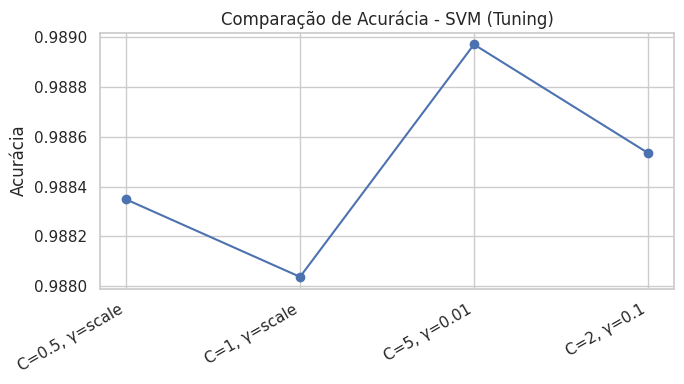

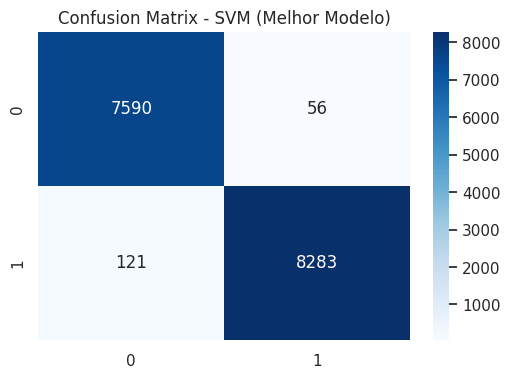

Classificação usando KNN: Tuning, Comparação e Resultados Finais
Tunning KNN
Treinando KNN com parâmetros: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}
Acurácia obtida: 0.9912
Treinando KNN com parâmetros: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}
Acurácia obtida: 0.9905
Treinando KNN com parâmetros: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}
Acurácia obtida: 0.9918
Treinando KNN com parâmetros: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}
Acurácia obtida: 0.9910
Melhor KNN encontrado:
{'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}
Acurácia: 0.9918380062305296


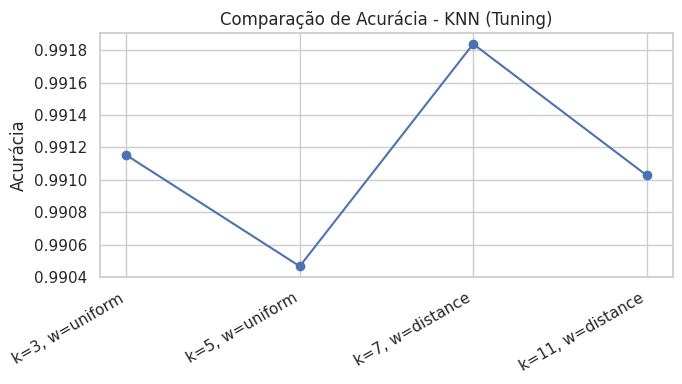

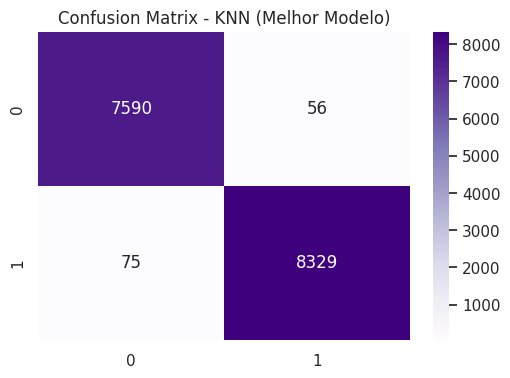

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classificação usando SVM: Tuning, Comparação e Resultados Finais")

# carregar tabelas
parquet_dir = Path("data/tidy")
files = {
  "games": parquet_dir / "games.parquet",
  "games_genres": parquet_dir / "games_genres.parquet",
  "games_platforms": parquet_dir / "games_platforms.parquet",
}

def read_table(path):
  if path.exists():
    try:
      return pd.read_parquet(path)
    except:
      pass
  return pd.read_csv(path.with_suffix(".csv"))

games = read_table(files["games"])
games_genres = read_table(files["games_genres"])
games_platforms = read_table(files["games_platforms"])

# engenharia de features
platform_count = games_platforms.groupby("appid")["platforms"].nunique().rename("platform_count")
games = games.merge(platform_count, on="appid", how="left")
games["platform_count"] = games["platform_count"].fillna(1)
games["is_multiplatform"] = (games["platform_count"] > 1).astype(int)

genre_count = games_genres.groupby("appid")["genres"].nunique().rename("genre_count")
games = games.merge(genre_count, on="appid", how="left")
games["genre_count"] = games["genre_count"].fillna(1)

games["total_reviews"] = games["positive"] + games["negative"]
games["positive_ratio"] = np.where(
  games["total_reviews"] > 0,
  games["positive"] / games["total_reviews"],
  0
)

# definir target baseado em múltiplos critérios de sucesso
games["success"] = (
  (games["owners"] > 500_000) |
  (games["userscore"] > 85) |
  (games["positive_ratio"] > 0.80)
).astype(int)

features = [
  "price_brl","is_multiplatform","genre_count","owners","average_forever",
  "average_2weeks","median_forever","ccu","positive","negative","userscore"
]

df = games[features + ["success"]].dropna()
X = df[features]
y = df["success"]

# dividir dados e aplicar escalonamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# tuning do svm com combinações fixas de hiperparâmetros
svm_params = [
  {"C": 0.5, "gamma": "scale", "kernel": "rbf"},
  {"C": 1,   "gamma": "scale", "kernel": "rbf"},
  {"C": 5,   "gamma": 0.01,    "kernel": "rbf"},
  {"C": 2,   "gamma": 0.1,     "kernel": "rbf"},
]

svm_results = []

print("Tunning SVM")

for params in svm_params:
  print(f"Treinando SVM com parâmetros: {params}")
  model = SVC(**params)
  model.fit(X_train_scaled, y_train)
  pred = model.predict(X_test_scaled)
  acc = accuracy_score(y_test, pred)
  svm_results.append((params, acc))
  print(f"Acurácia obtida: {acc:.4f}")

best_svm_params, best_svm_acc = max(svm_results, key=lambda x: x[1])
print("Melhor SVM encontrado:")
print(best_svm_params)
print(f"Acurácia: {best_svm_acc}")

# visualizar comparação de acurácia entre configurações
plt.figure(figsize=(7,4))
plt.plot(range(len(svm_results)), [acc for _, acc in svm_results], marker="o")

svm_labels = [
  f"C={p['C']}, γ={p['gamma']}" 
  for p, _ in svm_results
]

plt.xticks(range(len(svm_results)), svm_labels, rotation=30, ha="right")
plt.title("Comparação de Acurácia - SVM (Tuning)")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

# treinar modelo final com melhores parâmetros
svm_best_model = SVC(**best_svm_params)
svm_best_model.fit(X_train_scaled, y_train)
y_pred_best_svm = svm_best_model.predict(X_test_scaled)

# matriz de confusão do melhor modelo
cm_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM (Melhor Modelo)")
plt.show()

from sklearn.neighbors import KNeighborsClassifier

print("Classificação usando KNN: Tuning, Comparação e Resultados Finais")

# tuning do knn com combinações fixas de hiperparâmetros
knn_params = [
  {"n_neighbors": 3, "weights": "uniform",   "metric": "minkowski"},
  {"n_neighbors": 5, "weights": "uniform",   "metric": "minkowski"},
  {"n_neighbors": 7, "weights": "distance",  "metric": "minkowski"},
  {"n_neighbors": 11,"weights": "distance",  "metric": "euclidean"},
]

knn_results = []

print("Tunning KNN")

for params in knn_params:
  print(f"Treinando KNN com parâmetros: {params}")
  model = KNeighborsClassifier(**params)
  model.fit(X_train_scaled, y_train)
  pred = model.predict(X_test_scaled)
  acc = accuracy_score(y_test, pred)
  knn_results.append((params, acc))
  print(f"Acurácia obtida: {acc:.4f}")

best_knn_params, best_knn_acc = max(knn_results, key=lambda x: x[1])
print("Melhor KNN encontrado:")
print(best_knn_params)
print(f"Acurácia: {best_knn_acc}")

# visualizar comparação de acurácia entre configurações
plt.figure(figsize=(7,4))
plt.plot(range(len(knn_results)), [acc for _, acc in knn_results], marker="o")
knn_labels = [
  f"k={p['n_neighbors']}, w={p['weights']}" 
  for p, _ in knn_results
]

plt.xticks(range(len(knn_results)), knn_labels, rotation=30, ha="right")
plt.title("Comparação de Acurácia - KNN (Tuning)")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

# treinar modelo final com melhores parâmetros
knn_best_model = KNeighborsClassifier(**best_knn_params)
knn_best_model.fit(X_train_scaled, y_train)
y_pred_best_knn = knn_best_model.predict(X_test_scaled)

# matriz de confusão do melhor modelo
cm_knn = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(6,4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - KNN (Melhor Modelo)")
plt.show()


# Classificação para Análise de Sucesso de Jogos: Relatório de Resultados

## Desempenho dos Modelos

### **Tuning do SVM**

Foram testadas quatro combinações de parâmetros:

| Parâmetros     | Acurácia   |
| -------------- | ---------- |
| C=0.5, γ=scale | 0.9883     |
| C=1, γ=scale   | 0.9880     |
| C=5, γ=0.01    | **0.9890** |
| C=2, γ=0.1     | 0.9885     |

**Melhor configuração encontrada:**

* **C = 5**, **gamma = 0.01**, **kernel = rbf**
* **Acurácia final:** **0.98897**

---

### **Tuning do KNN**

Foram testados quatro conjuntos de parâmetros:

| Parâmetros                  | Acurácia   |
| --------------------------- | ---------- |
| k=3, uniforme               | 0.9912     |
| k=5, uniforme               | 0.9905     |
| k=7, distância              | **0.9918** |
| k=11, distância, euclidiano | 0.9910     |

**Melhor configuração encontrada:**

* **k = 7**, **weights = distance**, **métrica = minkowski**
* **Acurácia final:** **0.99184**

---

## Comparação dos Modelos

| Modelo  | Melhor Acurácia | Observação                                                         |
| ------- | --------------- | ------------------------------------------------------------------ |
| **SVM** | 0.98897         | Altamente consistente, sensível ao ajuste de gamma                 |
| **KNN** | **0.99184**     | Melhor resultado geral, especialmente com ponderação por distância |

O modelo **KNN superou o SVM**, embora ambos tenham apresentado desempenho excelente, sugerindo que o padrão de vizinhança no espaço de features é muito relevante para a classificação.

---

## Conclusão

O desempenho dos modelos indica que os dados possuem forte separação natural entre jogos de sucesso e os demais, permitindo classificações altamente precisas.
O mercado gamer também se mostra diversificado, sem preferência restrita a poucos gêneros, indicando espaço para diferentes tipos de jogos prosperarem.
